In [14]:
import datetime
import glob
import requests
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytickersymbols import PyTickerSymbols

pd.set_option('max_colwidth', None)

['../data/lexisnexis/rwe/rwe_ag_06_11.xlsx', '../data/lexisnexis/rwe/rwe_ag_newspaper.xlsx', '../data/lexisnexis/rwe/rwe_ag_03_09.xlsx', '../data/lexisnexis/rwe/rwe_ag_newsletters.xlsx', '../data/lexisnexis/rwe/rwe_ag_12_22.xlsx', '../data/lexisnexis/rwe/rwe_ag_09_13.xlsx', '../data/lexisnexis/rwe/rwe_ag_12_17.xlsx', '../data/lexisnexis/rwe/rwe_ag_12_21.xlsx', '../data/lexisnexis/rwe/rwe_ag_08_10.xlsx', '../data/lexisnexis/rwe/rwe_ag_05_12.xlsx', '../data/lexisnexis/rwe/rwe_ag_07_15.xlsx']


,Headline,Publication,Summary,Date
0,RWE AG - 2010,"Germany Mining Report, 772 words",NaN,2010-07-20
1,RWE AG - 2010,"Germany Mining Report, 766 words",NaN,2010-01-01
2,RWE AG - 2011,"Germany Mining Report, 822 words",NaN,2011-01-01
3,DGAP-CMS: RWE AG : Release of a capital market information,"AWP OTS (Original text service) - English, ADHOC-NEWS; Energy, 540 words",NaN,2010-09-30
4,"RWE AG LNG Export and Import Markets, 2000 to 2015- Profile and Analysis and Forecasts of Terminal wise Capacity and Associated Contracts","M2 PressWIRE, 471 words",NaN,2010-09-30
...,...,...,...,...
985,University of Warsaw awards electricity distribution deal to RWE Stoen,"SeeNews Poland, 135 words",NaN,2014-05-27
986,"(1/4) Results for the Three and Nine Months Ended Sept. 30, 2013","Market News Publishing, 6457 words",NaN,2013-11-07
987,"Global Fuel Cells Market, Global Industry Analysts","PR Newswire, 6414 words",NaN,2014-10-16
988,"Global Fuel Cells Market, Global Industry Analysts","PR Newswire, 6422 words",NaN,2014-07-09


,time_stamp,title
0,2008-01-03,Municipal Investors Bundle Stakes in German RWE
1,2008-01-04,"German RWE Eprimo with 87,000 Customers in 2007"
2,2008-01-04,"RWE AG 's npower hikes UK gas prices by 17.2 pct, electricity by 12.7 pct"
3,2008-01-04,"RWE 's discount unit Eprimo adds 87,000 new customers in 2007 - report"
4,2008-01-09,Germany 's RWE to up stake in Budapest power company ELMU by around 10 pct
...,...,...
3122,2022-12-29,"Thursday December 29, 2022 RWE ADR Compendium - A Snapshot as of December 29"
3123,2022-12-29,- Sempra Infrastructure signs long-term sale and purchase agreement with RWE Supply Trading
3124,2022-12-29,Sempra subsidiary finalizes 15-year deal to supply US LNG to Germany 's RWE
3125,2022-12-29,RWE ADR (RWEOY: $44.40) increases 1.6% strengthening above moving average price; +68c [1.6%]


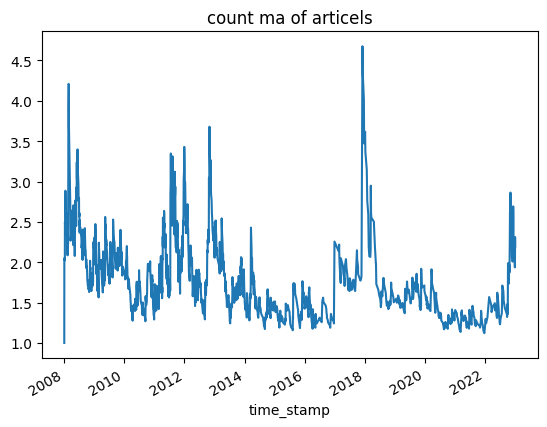

In [15]:
# get the absolute path of all Excel files 
rwe_news = glob.glob('../data/lexisnexis/rwe/*.xlsx')
print(rwe_news)

# read all Excel files at once
rwe_news = pd.concat([pd.read_excel(file) for file in rwe_news])
display(rwe_news)
rwe_news = rwe_news[['Date', 'Headline']]
rwe_news = rwe_news.rename(columns={
    'Date': 'time_stamp',
    'Headline': 'title'
})

rwe_news = rwe_news.dropna()
rwe_news = rwe_news.sort_values('time_stamp')
rwe_news = rwe_news.drop_duplicates(keep='first')
searchfor = ('rwe', 'innogy')
rwe_news = rwe_news[rwe_news['title'].str.lower().str.contains('|'.join(searchfor))]
rwe_news = rwe_news[rwe_news['title'].str.len() > 15]
rwe_news = rwe_news.reset_index(drop=True)

display(rwe_news)

rwe_news.groupby('time_stamp')['title'].count().ewm(halflife=7).mean().plot(
    kind='line',
    title='count ma of articels'
)
plt.show()

rwe_news.to_csv('../data/rwe_news_prep.csv', sep=';', index=False)

## Stock Price preprocessing

In [78]:
def get_stock_price(symbol, start='2010-01-01', end='2022-10-31'):
    url = "https://yahoo-finance97.p.rapidapi.com/price-customdate"

    payload = f"end={end}&symbol={symbol}&start={start}"
    headers = {
        "content-type": "application/x-www-form-urlencoded",
        "X-RapidAPI-Key": "",
        "X-RapidAPI-Host": "yahoo-finance97.p.rapidapi.com"
    }
    response = requests.request("POST", url, data=payload, headers=headers)
    
    df = response.text
    df = ast.literal_eval(df)
    df = df['data']
    df = pd.DataFrame(df)
    #display(df)
    df['Date'] = df['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).date())
    df.columns = [x.lower() for x in df.columns]
    df = df[[
        'date',
        'close'
    ]]
    
    return df

rwe_price = get_stock_price('^GDAXI', start='2008-01-01', end='2022-12-31')
rwe_price.to_csv('../data/dax_prices_raw.csv', sep=';', index=False)

In [3]:
def stock_ts_prep(path):
    df = pd.read_csv(path, sep=';', index_col='date')
    df.index.name = 'time_stamp'
    
    df = df.rename(columns={
        'close': 'price'
    })

    df.index = pd.to_datetime(df.index)

    df = df[df.index.dayofweek < 5]

    df = df.fillna(
        method='ffill',
        limit=5
    ).fillna(
        method='bfill',
        limit=5
    )

    df = np.log(df) - np.log(df.shift(1))
    df = df.fillna(0)

    return df

rwe_price = stock_ts_prep('../data/rwe_prices_raw.csv')
rwe_price.to_csv('../data/rwe_prices_prep.csv', sep=';')
display(rwe_price)

dax_price = stock_ts_prep('../data/dax_prices_raw.csv')
dax_price.to_csv('../data/dax_prices_prep.csv', sep=';')
display(dax_price)

rwe_news = pd.read_csv('../data/rwe_news_prep.csv', sep=';')
rwe_news['time_stamp'] = pd.to_datetime(rwe_news['time_stamp'])
rwe_news['time_stamp'] -= pd.to_timedelta((rwe_news['time_stamp'].dt.dayofweek - 4).clip(lower=0), unit='D')
rwe_news = rwe_news.groupby('time_stamp')['title'].apply(lambda x: ' '.join(x.values))
display(rwe_news)

dataset = rwe_price.merge(
    dax_price,
    left_index=True,
    right_on='time_stamp',
    how='left',
    suffixes=['_rwe', '_dax']
)
display(dataset)

dataset = dataset.fillna(0)

dataset['alpha'] = dataset['price_rwe'] - dataset['price_dax']

dataset = pd.merge_asof(
    dataset, rwe_news,
    on='time_stamp',
    tolerance=pd.Timedelta('5d'),
    direction='backward'
)
display(dataset)
dataset = dataset[['time_stamp', 'alpha', 'title']]

dataset.to_csv('../data/dataset.csv', sep=';', index=False)
display(dataset)

,price
time_stamp,
2008-01-02,0.000000
2008-01-03,0.027555
2008-01-04,-0.004095
2008-01-07,0.031409
2008-01-08,-0.011701
...,...
2022-12-23,-0.005516
2022-12-27,-0.000722
2022-12-28,-0.006035


,price
time_stamp,
2008-01-02,0.000000
2008-01-03,-0.005133
2008-01-04,-0.012690
2008-01-07,0.001085
2008-01-08,0.004190
...,...
2022-12-23,0.001929
2022-12-27,0.003878
2022-12-28,-0.004978


time_stamp
2008-01-03                                                                                                                                                                                                                                                                                                      Municipal Investors Bundle Stakes in German RWE
2008-01-04                                                                                                                                                     German RWE Eprimo with 87,000 Customers in 2007 RWE AG 's npower hikes UK gas prices by 17.2 pct, electricity by 12.7 pct RWE 's discount unit Eprimo adds 87,000 new customers in 2007 - report
2008-01-09                                                                                                                                                                                                             Germany 's RWE to up stake in Budapest power company ELMU by around 10

,time_stamp,price_rwe,price_dax
2008-01-02,2008-01-02,0.000000,0.000000
2008-01-03,2008-01-03,0.027555,-0.005133
2008-01-04,2008-01-04,-0.004095,-0.012690
2008-01-07,2008-01-07,0.031409,0.001085
2008-01-08,2008-01-08,-0.011701,0.004190
...,...,...,...
2022-12-23,2022-12-23,-0.005516,0.001929
2022-12-27,2022-12-27,-0.000722,0.003878
2022-12-28,2022-12-28,-0.006035,-0.004978
2022-12-29,2022-12-29,0.007959,0.010438


,time_stamp,price_rwe,price_dax,alpha,title
0,2008-01-02,0.000000,0.000000,0.000000,NaN
1,2008-01-03,0.027555,-0.005133,0.032688,Municipal Investors Bundle Stakes in German RWE
2,2008-01-04,-0.004095,-0.012690,0.008594,"German RWE Eprimo with 87,000 Customers in 2007 RWE AG 's npower hikes UK gas prices by 17.2 pct, electricity by 12.7 pct RWE 's discount unit Eprimo adds 87,000 new customers in 2007 - report"
3,2008-01-07,0.031409,0.001085,0.030323,"German RWE Eprimo with 87,000 Customers in 2007 RWE AG 's npower hikes UK gas prices by 17.2 pct, electricity by 12.7 pct RWE 's discount unit Eprimo adds 87,000 new customers in 2007 - report"
4,2008-01-08,-0.011701,0.004190,-0.015890,"German RWE Eprimo with 87,000 Customers in 2007 RWE AG 's npower hikes UK gas prices by 17.2 pct, electricity by 12.7 pct RWE 's discount unit Eprimo adds 87,000 new customers in 2007 - report"
...,...,...,...,...,...
3803,2022-12-23,-0.005516,0.001929,-0.007445,"Friday December 23, 2022 What Happened Today to the RWE ADR"
3804,2022-12-27,-0.000722,0.003878,-0.004600,"Tuesday December 27, 2022 What Happened Today to the RWE ADR RWE ADR (RWEOY: $44.09) strengthens above moving average price; +1c [0.02%] Vol Index 1.3 [1 is avg]"
3805,2022-12-28,-0.006035,-0.004978,-0.001057,"Sempra Inks Multi-year LNG Sale, Purchase Deal With RWE RWE ADR (RWEOY: $43.90) falls ; -8c [-0.2%] Sempra Infrastructure Announces Sale and Purchase Agreement with RWE for Port Arthur LNG Wednesday December 28, 2022 All You Need to Know About the RWE ADR Today"
3806,2022-12-29,0.007959,0.010438,-0.002480,"Thursday December 29, 2022 RWE ADR Compendium - A Snapshot as of December 29 - Sempra Infrastructure signs long-term sale and purchase agreement with RWE Supply Trading Sempra subsidiary finalizes 15-year deal to supply US LNG to Germany 's RWE RWE ADR (RWEOY: $44.40) increases 1.6% strengthening above moving average price; +68c [1.6%]"


,time_stamp,alpha,title
0,2008-01-02,0.000000,NaN
1,2008-01-03,0.032688,Municipal Investors Bundle Stakes in German RWE
2,2008-01-04,0.008594,"German RWE Eprimo with 87,000 Customers in 2007 RWE AG 's npower hikes UK gas prices by 17.2 pct, electricity by 12.7 pct RWE 's discount unit Eprimo adds 87,000 new customers in 2007 - report"
3,2008-01-07,0.030323,"German RWE Eprimo with 87,000 Customers in 2007 RWE AG 's npower hikes UK gas prices by 17.2 pct, electricity by 12.7 pct RWE 's discount unit Eprimo adds 87,000 new customers in 2007 - report"
4,2008-01-08,-0.015890,"German RWE Eprimo with 87,000 Customers in 2007 RWE AG 's npower hikes UK gas prices by 17.2 pct, electricity by 12.7 pct RWE 's discount unit Eprimo adds 87,000 new customers in 2007 - report"
...,...,...,...
3803,2022-12-23,-0.007445,"Friday December 23, 2022 What Happened Today to the RWE ADR"
3804,2022-12-27,-0.004600,"Tuesday December 27, 2022 What Happened Today to the RWE ADR RWE ADR (RWEOY: $44.09) strengthens above moving average price; +1c [0.02%] Vol Index 1.3 [1 is avg]"
3805,2022-12-28,-0.001057,"Sempra Inks Multi-year LNG Sale, Purchase Deal With RWE RWE ADR (RWEOY: $43.90) falls ; -8c [-0.2%] Sempra Infrastructure Announces Sale and Purchase Agreement with RWE for Port Arthur LNG Wednesday December 28, 2022 All You Need to Know About the RWE ADR Today"
3806,2022-12-29,-0.002480,"Thursday December 29, 2022 RWE ADR Compendium - A Snapshot as of December 29 - Sempra Infrastructure signs long-term sale and purchase agreement with RWE Supply Trading Sempra subsidiary finalizes 15-year deal to supply US LNG to Germany 's RWE RWE ADR (RWEOY: $44.40) increases 1.6% strengthening above moving average price; +68c [1.6%]"
